In [ ]:
!pip install tensorflow-addons --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
!pip install tensorflow --upgrade
!pip install keras --upgrade
!pip install tensorflow-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.2/230.2 MB 4.6 MB/s eta 0:00:00


In [6]:
# Import the necessary packages
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, Sequential, clone_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LayerNormalization, GlobalAveragePooling2D, Input, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers.schedules import CosineDecay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import ResNet50
from sklearn.utils import class_weight
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import ConvNeXtTiny
import cv2
from collections import deque
import random

In [2]:
# Setting a consistent random seed for reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load the data from csv
data = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/RL-AutoNav/training_frame_metadata.csv')
test_data = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/RL-AutoNav/test_frame_metadata.csv')
data.head()

,video_id,frame_number,label,frame_id,file_path
0,2.mp4,1,Left,2.mp4_left_1.jpg,/content/drive/MyDrive/Colab Notebooks/RL-Auto...
1,2.mp4,2,Left,2.mp4_left_2.jpg,/content/drive/MyDrive/Colab Notebooks/RL-Auto...
2,2.mp4,3,Left,2.mp4_left_3.jpg,/content/drive/MyDrive/Colab Notebooks/RL-Auto...
3,2.mp4,4,Left,2.mp4_left_4.jpg,/content/drive/MyDrive/Colab Notebooks/RL-Auto...
4,2.mp4,5,Left,2.mp4_left_5.jpg,/content/drive/MyDrive/Colab Notebooks/RL-Auto...


In [5]:
test_data.head()

,video_id,frame_number,label,frame_id,file_path
0,1.mp4,1,Right,1.mp4_right_1.jpg,/content/drive/MyDrive/Colab Notebooks/RL-Auto...
1,1.mp4,2,Right,1.mp4_right_2.jpg,/content/drive/MyDrive/Colab Notebooks/RL-Auto...
2,1.mp4,3,Right,1.mp4_right_3.jpg,/content/drive/MyDrive/Colab Notebooks/RL-Auto...
3,1.mp4,4,Right,1.mp4_right_4.jpg,/content/drive/MyDrive/Colab Notebooks/RL-Auto...
4,1.mp4,5,Right,1.mp4_right_5.jpg,/content/drive/MyDrive/Colab Notebooks/RL-Auto...


In [ ]:
data.columns

Index(['video_id', 'frame_number', 'label', 'frame_id', 'file_path'], dtype='object')

In [ ]:
# Check the data for any missing values or correct datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5655 entries, 0 to 5654
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   video_id      5655 non-null   object
 1   frame_number  5655 non-null   int64 
 2   label         5655 non-null   object
 3   frame_id      5655 non-null   object
 4   file_path     5655 non-null   object
dtypes: int64(1), object(4)
memory usage: 221.0+ KB


In [ ]:
# Basic Descriptive Statistics
statistics = data.describe()
statistics.style.background_gradient(cmap='Greens')

,frame_number
count,5655.000000
mean,3.000000
std,1.414339
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,5.000000


In [ ]:
# Check for duplicate rows
duplicates = data.duplicated().sum()
duplicates

0

In [ ]:
# Count occurrences of each label
label_counts = data['label'].value_counts()
label_counts

,count
label,
Right,2218
Forward,1376
Stop,1054
Left,1007


In [ ]:
# Check for missing values in each column
missing_values = data.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
video_id        0
frame_number    0
label           0
frame_id        0
file_path       0
dtype: int64


In [ ]:
# Check unique values in 'label' and 'video_id'
unique_labels = data['label'].unique()
print(f"Unique labels: {unique_labels}")

Unique labels: ['Left' 'Right' 'Forward' 'Stop']


# **Distribution Analysis**

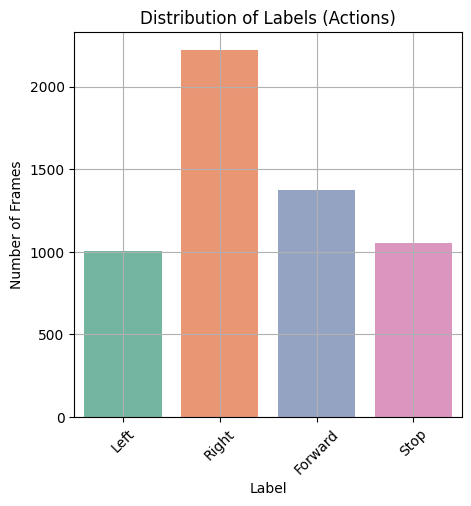

In [ ]:
# Plot the distribution of labels (actions)
plt.figure(figsize=(5, 5))
sns.countplot(data=data, x='label', hue='label', palette=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3'], legend=False)
plt.title('Distribution of Labels (Actions)')
plt.xlabel('Label')
plt.ylabel('Number of Frames')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

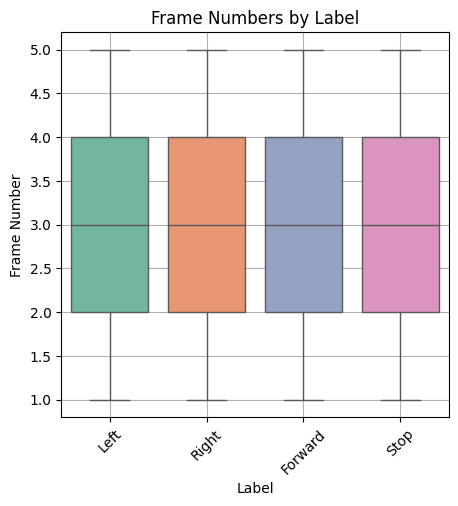

In [ ]:
# Countplot for label vs frame_number
plt.figure(figsize=(5, 5))
sns.boxplot(data=data, x='label', y='frame_number', hue='label', palette='Set2', legend=False)
plt.title('Frame Numbers by Label')
plt.xlabel('Label')
plt.ylabel('Frame Number')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

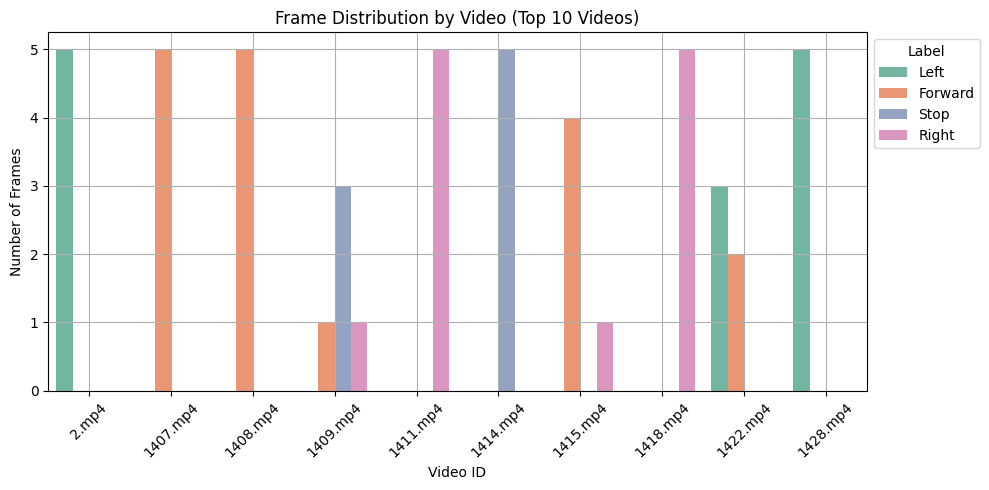

In [ ]:
# Plot the distribution of videos
# Get the top 10 video_ids by frequency
top_video_ids = data['video_id'].value_counts().nlargest(10).index
# Filter the data
filtered_data = data[data['video_id'].isin(top_video_ids)]

# Plot the distribution for the top 10 video_ids
plt.figure(figsize=(10, 5))
sns.countplot(data=filtered_data, x='video_id', hue='label', palette='Set2', legend=True)
plt.title('Frame Distribution by Video (Top 10 Videos)')
plt.xlabel('Video ID')
plt.ylabel('Number of Frames')
plt.xticks(rotation=45)
plt.legend(title='Label', bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

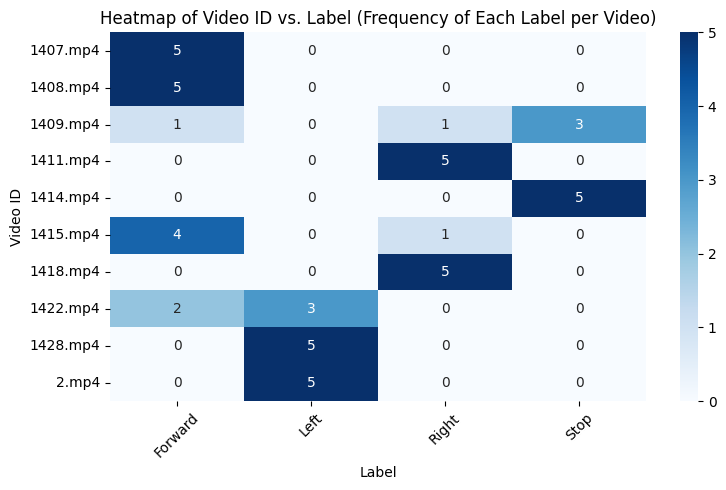

In [ ]:
# Heatmap of Video ID vs. Label (Frequency of Each Label per Video)
# Get the count of labels per video_id
label_counts = filtered_data.groupby(['video_id', 'label']).size().unstack(fill_value=0)
# Plot the heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(label_counts, cmap='Blues', annot=True, fmt='d', cbar=True)
# Customize the plot
plt.title('Heatmap of Video ID vs. Label (Frequency of Each Label per Video)')
plt.xlabel('Label')
plt.ylabel('Video ID')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **Data Preprocessing**

In [ ]:
# Load images efficiently
def load_images_and_labels(df):
    images, labels = [], []
    for _, row in df.iterrows():
        img_path, label = row['file_path'], row['label']
        img = load_img(img_path, target_size=(128, 128))  # Image Resizing
        img_array = img_to_array(img) / 255.0  # Normalization
        images.append(img_array)
        labels.append(label)

    return np.array(images), np.array(labels)

X_train, y_train = load_images_and_labels(data)
X_test, y_test = load_images_and_labels(test_data)

In [ ]:
# Encode labels
label_encoder = {label: idx for idx, label in enumerate(np.unique(data['label'].values))}
y_train = to_categorical([label_encoder[label] for label in data['label'].values])
y_test = to_categorical([label_encoder[label] for label in test_data['label'].values])

In [ ]:
# Compute class distribution before augmentation
unique, counts = np.unique(np.argmax(y_train, axis=1), return_counts=True)
print("Original class distribution:", dict(zip(unique, counts)))

Original class distribution: {0: 1376, 1: 1007, 2: 2218, 3: 1054}


In [ ]:
# Compute class weights before augmentation
y_train_indices_without_aug = np.argmax(y_train, axis=1)
class_weights_without_aug = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_indices_without_aug), y=y_train_indices_without_aug)
class_weight_dict_without_aug = {i: class_weights_without_aug[i] for i in range(len(class_weights_without_aug))}
print(f"Class Weights: {class_weight_dict_without_aug}")

Class Weights: {0: 1.0274345930232558, 1: 1.403922542204568, 2: 0.6373985572587917, 3: 1.3413187855787476}


# **Data Augmentation**

In [ ]:
# Data Augmentation to Balance Classes
datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.3, height_shift_range=0.3,
                             shear_range=0.3, zoom_range=0.3, horizontal_flip=True, fill_mode='nearest')

In [ ]:
TARGET_SAMPLES = 3000
# Get unique labels
unique_labels = np.unique(y_train.argmax(axis=1))
augmented_images = []
augmented_labels = []

# Balance dataset by augmenting underrepresented classes
for label in np.unique(np.argmax(y_train, axis=1)):
    class_indices = np.where(np.argmax(y_train, axis=1) == label)[0]
    class_images = X_train[class_indices]
    class_labels = y_train[class_indices]

    num_existing = len(class_images)
    num_to_generate = TARGET_SAMPLES - num_existing

    if num_to_generate <= 0:
        augmented_images.extend(class_images)
        augmented_labels.extend(class_labels)
        continue

    generated_images = []
    generated_labels = []

    for i in range(num_to_generate):
        img = class_images[i % num_existing]
        img = np.expand_dims(img, axis=0)  # Reshape for the generator
        augmented_img = next(datagen.flow(img, batch_size=1, seed=SEED))[0]  # Augment Image

        generated_images.append(augmented_img)
        generated_labels.append(class_labels[i % num_existing])

    augmented_images.extend(class_images)
    augmented_images.extend(generated_images)
    augmented_labels.extend(class_labels)
    augmented_labels.extend(generated_labels)

# Convert lists to NumPy arrays
X_train_aug = np.array(augmented_images)
y_train_aug = np.array(augmented_labels)

In [ ]:
# Compute new class distribution
unique, counts = np.unique(np.argmax(y_train_aug, axis=1), return_counts=True)
print("New class distribution:", dict(zip(unique, counts)))

New class distribution: {0: 3000, 1: 3000, 2: 3000, 3: 3000}


In [ ]:
# Compute class weights after augmentation
y_train_indices = np.argmax(y_train_aug, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_indices), y=y_train_indices)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(f"Class Weights: {class_weight_dict}")

Class Weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}


In [ ]:
# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

In [ ]:
# Use Focal Loss (to improve performance on underrepresented classes)
def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_pred = tf.keras.backend.clip(y_pred, 1e-7, 1 - 1e-7)
        loss = -y_true * (alpha * tf.keras.backend.pow((1 - y_pred), gamma) * tf.keras.backend.log(y_pred))
        return tf.keras.backend.mean(loss)
    return loss

# **RESNET MODEL CODE**


In [ ]:
# Load ResNet50 with pretrained weights (ImageNet)
ResNet50_model = tf.keras.applications.ResNet50(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
ResNet50_model.trainable = False  # Freeze all base model layers

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Define custom classification head
x = ResNet50_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)  # Regularization
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

# Get the number of classes from the label encoder
num_classes = len(label_encoder)
output_layer = Dense(num_classes, activation='softmax')  # Final output layer
# Connect the output layer to the previous layer
output = output_layer(x)
# Create final model
resnet_model = Model(inputs=ResNet50_model.input, outputs=output)

In [ ]:
# Compile the model
# resnet_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
# Compile the model using Focal Loss
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),loss=focal_loss(),metrics=['accuracy'])
resnet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,769,156 (94.49 MB)

 Trainable params: 1,181,444 (4.51 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Train the model
history = resnet_model.fit(datagen.flow(X_train_aug, y_train_aug, batch_size=32, shuffle=True),
                           epochs=50, class_weight=class_weight_dict,
                           validation_data=(X_test, y_test),
                           callbacks=[early_stopping, reduce_lr])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 948s 2s/step - accuracy: 0.2671 - loss: 0.0511 - val_accuracy: 0.1686 - val_loss: 0.0505 - learning_rate: 5.0000e-04
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 908s 2s/step - accuracy: 0.2663 - loss: 0.0488 - val_accuracy: 0.4190 - val_loss: 0.0480 - learning_rate: 5.0000e-04
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 905s 2s/step - accuracy: 0.2693 - loss: 0.0487 - val_accuracy: 0.4451 - val_loss: 0.0467 - learning_rate: 5.0000e-04
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 852s 2s/step - accuracy: 0.2785 - loss: 0.0486 - val_accuracy: 0.3856 - val_loss: 0.0477 - learning_rate: 5.0000e-04
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 909s 2s/step - accuracy: 0.2867 - loss: 0.0483 - val_accuracy: 0.3451 - val_loss: 0.0483 - learning_rate: 5.0000e-04
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2928 - loss: 0.0482
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
375/375 ━━━━━━━━━━━━━━━━━━━━ 908s 2s/step - accuracy: 

In [ ]:
# Evaluate on train and test data
train_loss_resnet, resnet_train_accuracy = resnet_model.evaluate(X_train, y_train)
test_loss_resnet, resnet_test_accuracy = resnet_model.evaluate(X_test, y_test)
print(f"Resnet Train Accuracy: {resnet_train_accuracy:.2f}")
print(f"Resnet Train Loss: {train_loss_resnet}")
print(f"Resnet Test Accuracy: {resnet_test_accuracy:.2f}")
print(f"Resnet Test Loss: {test_loss_resnet}")

177/177 ━━━━━━━━━━━━━━━━━━━━ 335s 2s/step - accuracy: 0.3872 - loss: 0.0471
48/48 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.4585 - loss: 0.0460
Resnet Train Accuracy: 0.39
Resnet Train Loss: 0.047059137374162674
Resnet Test Accuracy: 0.45
Resnet Test Loss: 0.04630674049258232


In [ ]:
# Generate classification report and per-class accuracy
y_pred = resnet_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

report = classification_report(y_true_classes, y_pred_classes, target_names=list(label_encoder.keys()), output_dict=True)
print("Classification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=list(label_encoder.keys())))

48/48 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step
Classification Report:

              precision    recall  f1-score   support

     Forward       0.00      0.00      0.00       308
        Left       0.20      0.05      0.08       281
       Right       0.47      0.93      0.62       701
        Stop       0.22      0.06      0.10       240

    accuracy                           0.45      1530
   macro avg       0.22      0.26      0.20      1530
weighted avg       0.29      0.45      0.32      1530



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [ ]:
# Per-Class Accuracy
per_class_accuracy = {label: report[label]['recall'] * 100 for label in label_encoder.keys()}
print("Per-Class Accuracy:\n")
for label, acc in per_class_accuracy.items():
    print(f"{label}: {acc:.2f}%")

Per-Class Accuracy:

Forward: 0.00%
Left: 5.34%
Right: 93.01%
Stop: 6.25%


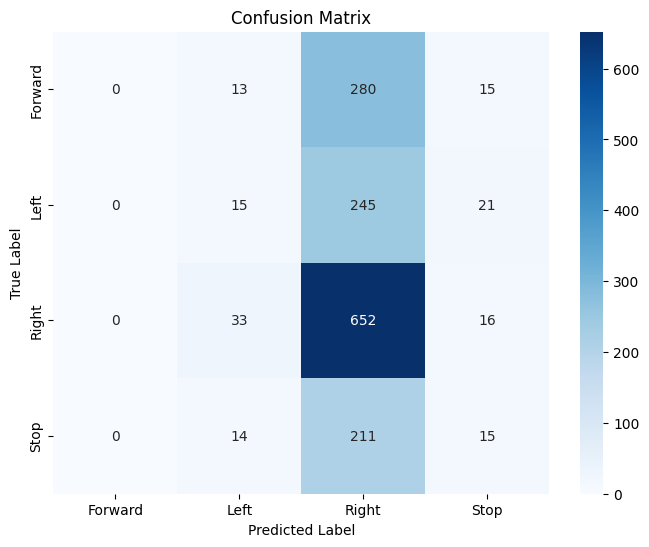

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.keys(), yticklabels=label_encoder.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

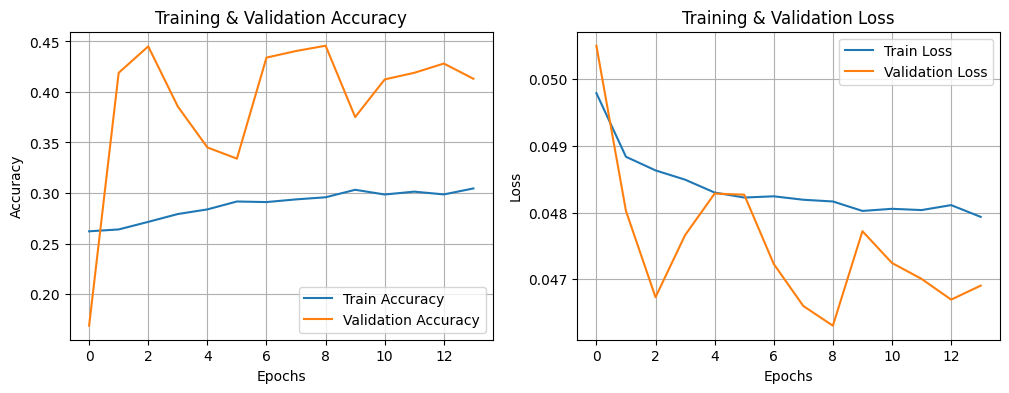

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

# **EfficientNet Model**

In [ ]:
EfficientNetB0_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(128, 128, 3))
EfficientNetB0_model.trainable = False  # Freeze the pre-trained weights

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Define custom classification head
x = GlobalAveragePooling2D()(EfficientNetB0_model.output)
x = BatchNormalization()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.4)(x)
# Get the number of classes from the label encoder
num_classes = len(label_encoder)
x = Dense(num_classes, activation="softmax")(x)

# Create final model
EfficientNetB0_model = Model(inputs=EfficientNetB0_model.input, outputs=x)

In [ ]:
# Compile the model
#EfficientNetB0_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
# Compile the model using Focal Loss
EfficientNetB0_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),loss=focal_loss(),metrics=['accuracy'])
EfficientNetB0_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 128, 128, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 128, 128, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 128, 128, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 129, 129, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 64, 64, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 64, 64, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 64, 64, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 64, 64, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 64, 64, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 64, 64, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,383,655 (16.72 MB)

 Trainable params: 331,524 (1.26 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [ ]:
# Train the model
history = EfficientNetB0_model.fit(datagen.flow(X_train_aug, y_train_aug, batch_size=32, shuffle=True),
                           epochs=50, class_weight=class_weight_dict,
                           validation_data=(X_test, y_test),
                           callbacks=[early_stopping, reduce_lr])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 188s 475ms/step - accuracy: 0.2516 - loss: 0.0638 - val_accuracy: 0.1837 - val_loss: 0.0488 - learning_rate: 5.0000e-04
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 178s 475ms/step - accuracy: 0.2651 - loss: 0.0547 - val_accuracy: 0.2078 - val_loss: 0.0488 - learning_rate: 5.0000e-04
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 177s 472ms/step - accuracy: 0.2575 - loss: 0.0517 - val_accuracy: 0.1876 - val_loss: 0.0487 - learning_rate: 5.0000e-04
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.2671 - loss: 0.0499
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
375/375 ━━━━━━━━━━━━━━━━━━━━ 176s 469ms/step - accuracy: 0.2671 - loss: 0.0499 - val_accuracy: 0.1869 - val_loss: 0.0487 - learning_rate: 5.0000e-04
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 177s 471ms/step - accuracy: 0.2661 - loss: 0.0490 - val_accuracy: 0.2046 - val_loss: 0.0487 - learning_rate: 2.5000e-04
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 178s 47

In [ ]:
# Evaluate on train and test data
train_loss_EfficientNetB0, EfficientNetB0_train_accuracy = EfficientNetB0_model.evaluate(X_train, y_train)
test_loss_EfficientNetB0, EfficientNetB0_test_accuracy = EfficientNetB0_model.evaluate(X_test, y_test)
print(f"EfficientNetB0 Train Accuracy: {EfficientNetB0_train_accuracy:.2f}")
print(f"EfficientNetB0 Train Loss: {train_loss_EfficientNetB0}")
print(f"EfficientNetB0 Test Accuracy: {EfficientNetB0_test_accuracy:.2f}")
print(f"EfficientNetB0 Test Loss: {test_loss_EfficientNetB0}")

177/177 ━━━━━━━━━━━━━━━━━━━━ 69s 391ms/step - accuracy: 0.2621 - loss: 0.0486
48/48 ━━━━━━━━━━━━━━━━━━━━ 19s 386ms/step - accuracy: 0.2999 - loss: 0.0486
EfficientNetB0 Train Accuracy: 0.26
EfficientNetB0 Train Loss: 0.04862027242779732
EfficientNetB0 Test Accuracy: 0.28
EfficientNetB0 Test Loss: 0.048575159162282944


In [ ]:
# Generate classification report and per-class accuracy
y_pred = EfficientNetB0_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

report = classification_report(y_true_classes, y_pred_classes, target_names=list(label_encoder.keys()), output_dict=True)
print("Classification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=list(label_encoder.keys())))

48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 395ms/step
Classification Report:

              precision    recall  f1-score   support

     Forward       0.00      0.00      0.00       308
        Left       0.19      0.77      0.31       281
       Right       0.52      0.31      0.39       701
        Stop       0.00      0.00      0.00       240

    accuracy                           0.28      1530
   macro avg       0.18      0.27      0.18      1530
weighted avg       0.28      0.28      0.24      1530



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [ ]:
# Per-Class Accuracy
per_class_accuracy = {label: report[label]['recall'] * 100 for label in label_encoder.keys()}
print("Per-Class Accuracy:\n")
for label, acc in per_class_accuracy.items():
    print(f"{label}: {acc:.2f}%")

Per-Class Accuracy:

Forward: 0.00%
Left: 76.51%
Right: 31.38%
Stop: 0.00%


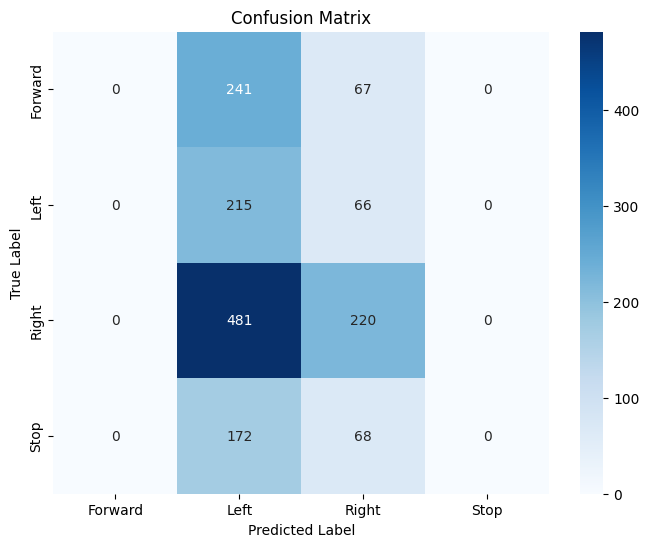

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.keys(), yticklabels=label_encoder.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

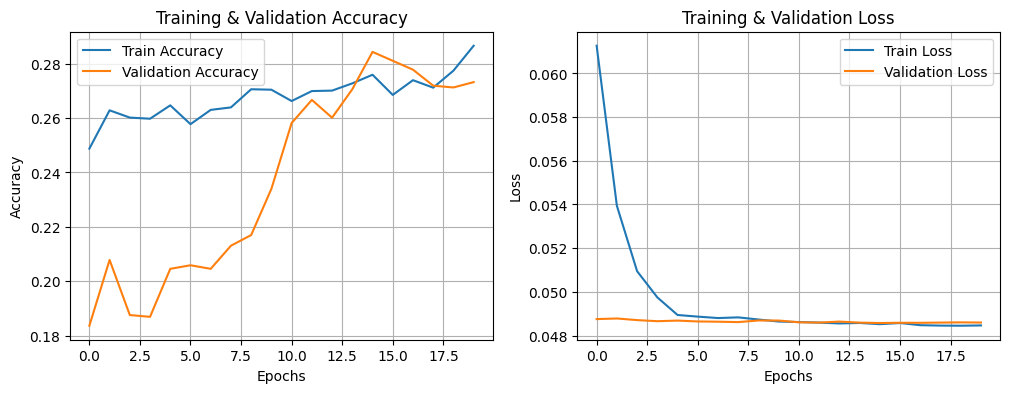

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

# **ConvNeXt Model**

In [ ]:
ConvNeXtTiny_model = ConvNeXtTiny(weights="imagenet", include_top=False, input_shape=(128, 128, 3))
ConvNeXtTiny_model.trainable = False  # Freeze the pre-trained weights

111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Define custom classification head
x = GlobalAveragePooling2D()(ConvNeXtTiny_model.output)
x = BatchNormalization()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.4)(x)
# Get the number of classes from the label encoder
num_classes = len(label_encoder)
x = Dense(num_classes, activation="softmax")(x)

# Create final model
ConvNeXtTiny_model = Model(inputs=ConvNeXtTiny_model.input, outputs=x)

In [ ]:
# Compile the model
ConvNeXtTiny_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
ConvNeXtTiny_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_tiny_prestem_no… │ (None, 128, 128, 3)    │              0 │ input_layer[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_tiny_stem        │ (None, 32, 32, 96)     │          4,896 │ convnext_tiny_prestem… │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_tiny_stage_0_bl… │ (None, 32, 32, 96)     │          4,800 │ convnext_tiny_stem[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_tiny_stage_0_bl… │ (None, 32, 32, 96)     │            192 │ convnext_tiny_stage_0… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_tiny_stage_0_bl… │ (None, 32, 32, 384)    │         37,248 │ convnext_tiny_stage_0… │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_tiny_stage_0_bl… │ (None, 32, 32, 384)    │              0 │ convnext_tiny_stage_0… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_tiny_stage_0_bl… │ (None, 32, 32, 96)     │         36,960 │ convnext_tiny_stage_0… │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_tiny_stage_0_bl… │ (None, 32, 32, 96)     │             96 │ convnext_tiny_stage_0… │
│ (LayerScale)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_tiny_stage_0_bl… │ (None, 32, 32, 96)     │              0 │ convnext_tiny_stage_0… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 96)     │              0 │ convnext_tiny_stem[0]… │
│                           │                        │                │ convnext_tiny_stage_0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_tiny_stage_0_bl… │ (None, 32, 32, 96)     │          4,800 │ add[0][0]              │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_tiny_stage_0_bl… │ (None, 32, 32, 96)     │            192 │ convnext_tiny_stage_0… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_tiny_stage_0

 Total params: 28,218,980 (107.65 MB)

 Trainable params: 397,316 (1.52 MB)

 Non-trainable params: 27,821,664 (106.13 MB)

In [ ]:
# Train the model
history = ConvNeXtTiny_model.fit(datagen.flow(X_train, y_train, batch_size=32, shuffle=True),  epochs=30, class_weight=class_weight_dict_without_aug,
                           validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 1994s 11s/step - accuracy: 0.2860 - loss: 1.7874 - val_accuracy: 0.2405 - val_loss: 1.4478 - learning_rate: 0.0100
Epoch 2/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 1997s 11s/step - accuracy: 0.3082 - loss: 1.6198 - val_accuracy: 0.2157 - val_loss: 1.5197 - learning_rate: 0.0100
Epoch 3/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 1971s 11s/step - accuracy: 0.3279 - loss: 1.5553 - val_accuracy: 0.3144 - val_loss: 1.4302 - learning_rate: 0.0100
Epoch 4/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 1992s 11s/step - accuracy: 0.3371 - loss: 1.4839 - val_accuracy: 0.3059 - val_loss: 1.6911 - learning_rate: 0.0100
Epoch 5/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 1999s 11s/step - accuracy: 0.3726 - loss: 1.3900 - val_accuracy: 0.2477 - val_loss: 1.7766 - learning_rate: 0.0100
Epoch 6/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.4001 - loss: 1.3482
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
177/177 ━━━━━━━━━━━━━━━━━━━━ 1996s 11s/step - accuracy: 0.4001 - 

In [ ]:
# Evaluate on train and test data
train_loss_ConvNeXtTiny, ConvNeXtTiny_train_accuracy = ConvNeXtTiny_model.evaluate(X_train, y_train)
test_loss_ConvNeXtTiny, ConvNeXtTiny_test_accuracy = ConvNeXtTiny_model.evaluate(X_test, y_test)
print(f"ConvNeXtTiny Train Accuracy: {ConvNeXtTiny_train_accuracy:.2f}")
print(f"ConvNeXtTiny Test Accuracy: {ConvNeXtTiny_test_accuracy:.2f}")

177/177 ━━━━━━━━━━━━━━━━━━━━ 1548s 9s/step - accuracy: 0.3998 - loss: 1.2877
48/48 ━━━━━━━━━━━━━━━━━━━━ 416s 9s/step - accuracy: 0.3106 - loss: 1.4193
ConvNeXtTiny Train Accuracy: 0.43
ConvNeXtTiny Test Accuracy: 0.31


In [ ]:
# Generate classification report and per-class accuracy
y_pred = ConvNeXtTiny_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

report = classification_report(y_true_classes, y_pred_classes, target_names=list(label_encoder.keys()), output_dict=True)
print("Classification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=list(label_encoder.keys())))

48/48 ━━━━━━━━━━━━━━━━━━━━ 425s 9s/step
Classification Report:

              precision    recall  f1-score   support

     Forward       0.22      0.33      0.27       308
        Left       0.19      0.08      0.11       281
       Right       0.47      0.42      0.44       701
        Stop       0.20      0.26      0.22       240

    accuracy                           0.31      1530
   macro avg       0.27      0.27      0.26      1530
weighted avg       0.33      0.31      0.31      1530



In [ ]:
# Per-Class Accuracy
per_class_accuracy = {label: report[label]['recall'] * 100 for label in label_encoder.keys()}
print("Per-Class Accuracy:\n")
for label, acc in per_class_accuracy.items():
    print(f"{label}: {acc:.2f}%")

Per-Class Accuracy:

Forward: 33.44%
Left: 8.19%
Right: 41.65%
Stop: 26.25%


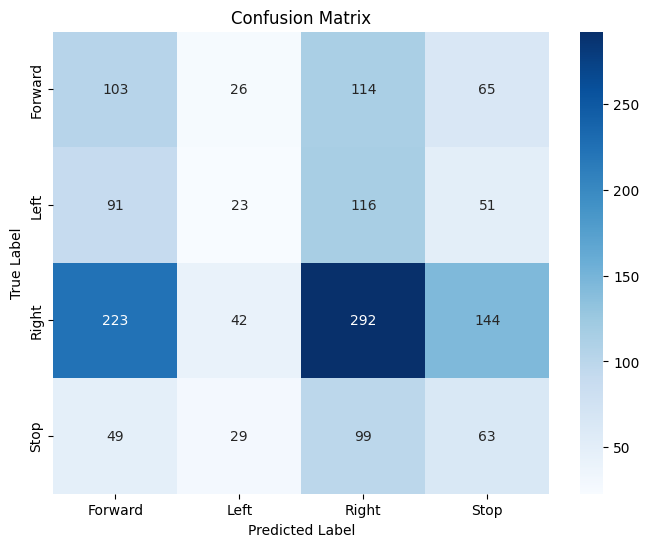

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.keys(), yticklabels=label_encoder.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

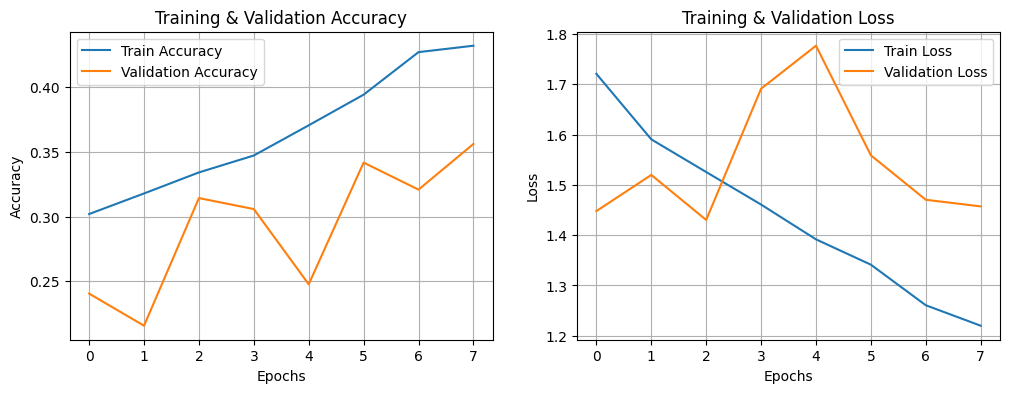

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

# **Custom CNN Model**  

In [ ]:
def custom_cnn(input_shape, num_classes):
    model = Sequential([Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
                        MaxPooling2D((2, 2)),
                        Conv2D(64, (3, 3), activation='relu'),
                        MaxPooling2D((2, 2)),
                        Conv2D(128, (3, 3), activation='relu'),
                        MaxPooling2D((2, 2)),
                        Flatten(),
                        Dense(128, activation='relu'),
                        Dropout(0.5),
                        Dense(num_classes, activation='softmax')])
    return model

cnn_model = custom_cnn(input_shape=(128, 128, 3), num_classes=len(label_encoder))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
# Using SGD with momentum for better generalization
cnn_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [ ]:
# Model Training with Callbacks and Class Weights
history = cnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32,
                        class_weight=class_weight_dict_without_aug, callbacks=[early_stopping, reduce_lr])

Epoch 1/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 110s 617ms/step - accuracy: 0.2722 - loss: 1.3835 - val_accuracy: 0.4601 - val_loss: 1.2854 - learning_rate: 0.0100
Epoch 2/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 141s 610ms/step - accuracy: 0.3846 - loss: 1.3251 - val_accuracy: 0.4556 - val_loss: 1.2791 - learning_rate: 0.0100
Epoch 3/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 144s 620ms/step - accuracy: 0.4284 - loss: 1.2764 - val_accuracy: 0.5072 - val_loss: 1.2166 - learning_rate: 0.0100
Epoch 4/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 109s 618ms/step - accuracy: 0.4707 - loss: 1.2002 - val_accuracy: 0.4235 - val_loss: 1.2851 - learning_rate: 0.0100
Epoch 5/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 141s 616ms/step - accuracy: 0.5540 - loss: 1.0775 - val_accuracy: 0.4209 - val_loss: 1.3470 - learning_rate: 0.0100
Epoch 6/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 143s 618ms/step - accuracy: 0.6442 - loss: 0.8691 - val_accuracy: 0.4196 - val_loss: 1.4121 - learning_rate: 0.0100
Epoch 7/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 141s 612ms/step - accura

In [ ]:
# Evaluate on train and test data
train_loss_custom_cnn, custom_cnn_train_accuracy = cnn_model.evaluate(X_train, y_train)
test_loss_custom_cnn, custom_cnn_test_accuracy = cnn_model.evaluate(X_test, y_test)
print(f"Custom CNN Train Accuracy: {custom_cnn_train_accuracy:.2f}")
print(f"Custom CNN Train Loss: {train_loss_custom_cnn}")
print(f"Custom CNN Test Accuracy: {custom_cnn_test_accuracy:.2f}")
print(f"Custom CNN Test Loss: {test_loss_custom_cnn}")

177/177 ━━━━━━━━━━━━━━━━━━━━ 29s 163ms/step - accuracy: 0.5081 - loss: 1.1530
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 0.5194 - loss: 1.2134
Custom CNN Train Accuracy: 0.50
Custom CNN Train Loss: 1.1678141355514526
Custom CNN Test Accuracy: 0.51
Custom CNN Test Loss: 1.2166168689727783


In [ ]:
# Generate classification report and per-class accuracy
y_pred = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

report = classification_report(y_true_classes, y_pred_classes, target_names=list(label_encoder.keys()), output_dict=True)
print("Classification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=list(label_encoder.keys())))

48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step
Classification Report:

              precision    recall  f1-score   support

     Forward       0.44      0.29      0.35       308
        Left       0.34      0.59      0.43       281
       Right       0.63      0.70      0.67       701
        Stop       0.43      0.13      0.20       240

    accuracy                           0.51      1530
   macro avg       0.46      0.43      0.41      1530
weighted avg       0.51      0.51      0.49      1530



In [ ]:
# Per-Class Accuracy
per_class_accuracy = {label: report[label]['recall'] * 100 for label in label_encoder.keys()}
print("Per-Class Accuracy:\n")
for label, acc in per_class_accuracy.items():
    print(f"{label}: {acc:.2f}%")

Per-Class Accuracy:

Forward: 28.57%
Left: 58.72%
Right: 70.19%
Stop: 12.92%


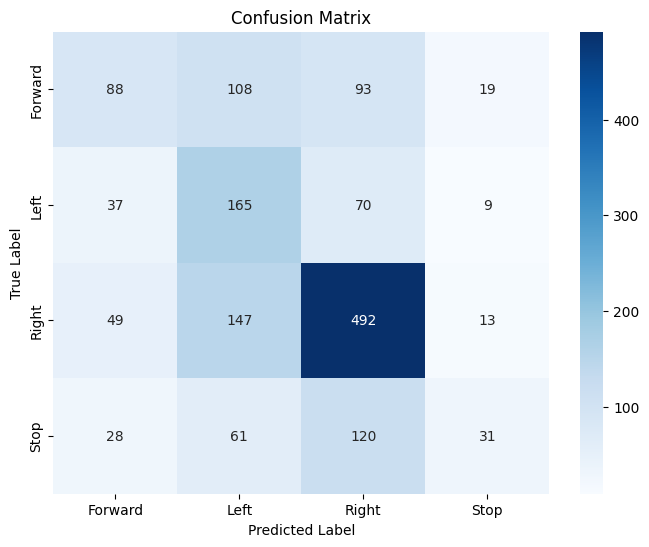

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.keys(), yticklabels=label_encoder.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

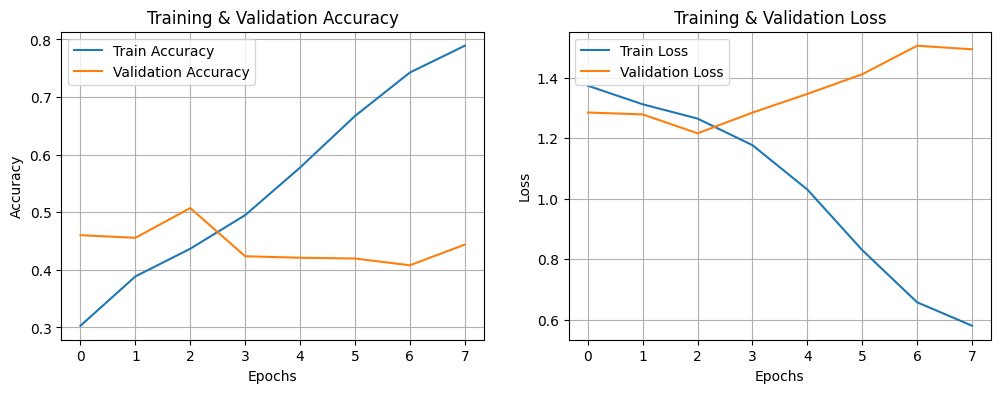

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

In [ ]:
cnn_model.save('/content/drive/MyDrive/Colab Notebooks/RL-AutoNav/cnn_model.h5')

# **Plotting Accuracy & Loss Comparison**

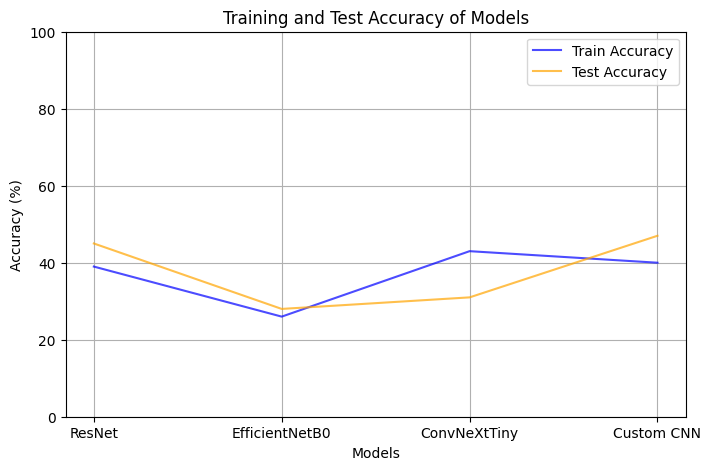

In [26]:
# Model names
models_ = ['ResNet', 'EfficientNetB0', 'ConvNeXtTiny', 'Custom CNN']
# Train and test accuracy values
train_accuracies = [resnet_train_accuracy, EfficientNetB0_train_accuracy, ConvNeXtTiny_train_accuracy, custom_cnn_train_accuracy]
train_accuracies = [acc * 100 for acc in train_accuracies]
test_accuracies = [resnet_test_accuracy, EfficientNetB0_test_accuracy, ConvNeXtTiny_test_accuracy, custom_cnn_test_accuracy]
test_accuracies = [acc * 100 for acc in test_accuracies]
x = np.arange(len(models_))  # X-axis positions

plt.figure(figsize=(8, 5))
# Plot Training and Test Accuracies
plt.plot(x, train_accuracies, color='blue', alpha=0.7, label='Train Accuracy')
plt.plot(x, test_accuracies, color='orange', alpha=0.7, label='Test Accuracy')

plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy of Models')
plt.xticks(x, models_)
plt.ylim(0, 100)  # Assuming accuracy is between 0 and 100
plt.grid(True)
plt.legend()
plt.show()

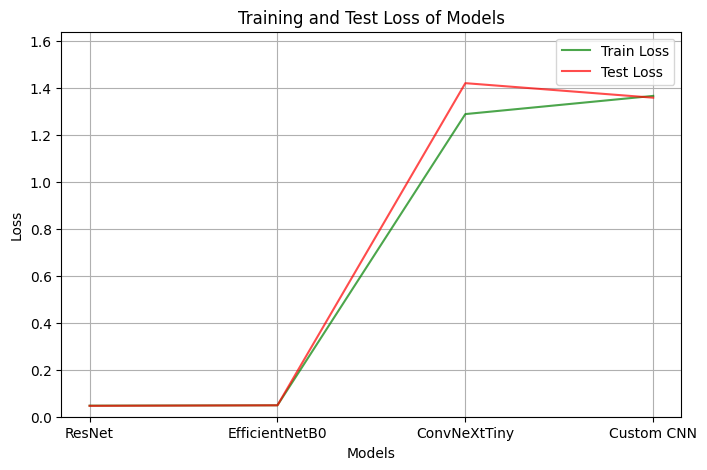

In [27]:
# Model names
models_ = ['ResNet', 'EfficientNetB0', 'ConvNeXtTiny', 'Custom CNN']
# Train and test loss values
train_losses = [train_loss_resnet, train_loss_EfficientNetB0, train_loss_ConvNeXtTiny, train_loss_custom_cnn]
test_losses = [test_loss_resnet, test_loss_EfficientNetB0, test_loss_ConvNeXtTiny, test_loss_custom_cnn]
x = np.arange(len(models_))  # X-axis positions

plt.figure(figsize=(8, 5))
# Plot Training and Test Accuracies
plt.plot(x, train_losses, color='green', alpha=0.7, label='Train Loss')
plt.plot(x, test_losses, color='red', alpha=0.7, label='Test Loss')

plt.xlabel('Models')
plt.ylabel('Loss')
plt.title('Training and Test Loss of Models')
plt.xticks(x, models_)
plt.ylim(0, max(train_losses) * 1.2)  # Scaling y-axis slightly for better visibility
plt.grid(True)
plt.legend()
plt.show()

# **RL Model**  

In [8]:
cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/RL-AutoNav/cnn_model.h5')
# Compile the model
# Using SGD with momentum for better generalization
cnn_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
def custom_cnn_base(cnn_model, unfreeze_all=False, unfreeze_layers=-3):
  input_shape = cnn_model.input_shape[1:]
  inputs = tf.keras.Input(shape=input_shape)
  x = inputs

  # Decide which layers to unfreeze
  if unfreeze_all:
      for layer in cnn_model.layers:
          layer.trainable = True
  else:
      for layer in cnn_model.layers[:unfreeze_layers]:
          layer.trainable = False
      for layer in cnn_model.layers[unfreeze_layers:]:
          layer.trainable = True

  # Rebuild the CNN base
  for layer in cnn_model.layers:
      x = layer(x)
  cnn_base = Model(inputs=inputs, outputs=x)
  return cnn_base

In [29]:
# Hyperparameters
GAMMA = 0.99
EPSILON = 1.0
EPSILON_MIN = 0.05  # Slower decay for better exploration
EPSILON_DECAY = 0.995
BATCH_SIZE = 64
MEMORY_SIZE = 50000  # more diverse experience
LEARNING_RATE = 0.0005  # for better convergence
TARGET_UPDATE_FREQ = 5  # More frequent target network

In [30]:
# Prioritized Experience Replay
class PrioritizedReplayBuffer:
    def __init__(self, size):
        self.memory = deque(maxlen=size)
        self.priorities = deque(maxlen=size)

    def add(self, experience, error):
        self.memory.append(experience)
        self.priorities.append(error + 1e-5)  # Avoid zero priority

    def sample(self, batch_size):
        priorities = np.array(self.priorities)
        probs = priorities / priorities.sum()
        indices = np.random.choice(len(self.memory), batch_size, p=probs)
        batch = [self.memory[i] for i in indices]
        return batch, indices

    def update_priorities(self, indices, errors):
        for i, error in zip(indices, errors):
            self.priorities[i] = error + 1e-5

memory = PrioritizedReplayBuffer(MEMORY_SIZE)

In [31]:
# Building the Deep Q-Network
def build_dqn(action_size):
    inputs = Input(shape=(128, 128, 3))
    cnn_base = custom_cnn_base(cnn_model)
    features = cnn_base(inputs)  # Feature extraction
    x = Dense(128, activation='relu')(features)
    outputs = Dense(action_size, activation='linear')(x)  # Q-values
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

In [32]:
# Defining the Environment
class DrivingEnv:
    def __init__(self, csv_path):
        self.data = pd.read_csv(csv_path)
        self.actions = ['Left', 'Right', 'Forward', 'Stop']
        self.current_index = 0
        self.done = False
        self.step_count = 0

    def reset(self):
        self.current_index = 0
        self.done = False
        self.step_count = 0
        return self._load_frame(self.current_index)

    def _load_frame(self, index):
        random_offset = random.randint(-5, 5) # Adjust the range as needed
        new_index = max(0, min(index + random_offset, len(self.data) - 1))
        frame_path = self.data.iloc[new_index]['file_path']
        image = cv2.imread(frame_path)
        image = cv2.resize(image, (128, 128))
        image = image / 255.0
        return image

    def step(self, action):
        """Perform one step in the environment."""
        correct_action = self.actions.index(self.data.iloc[self.current_index]['label'])
        reward = 1 if action == correct_action else -1
        self.step_count += 1
        self.current_index += 1
        if self.current_index >= len(self.data):
            self.done = True
        return self._load_frame(self.current_index - 1), reward, self.done

In [33]:
data = '/content/drive/MyDrive/Colab Notebooks/RL-AutoNav/training_frame_metadata.csv'
env = DrivingEnv(data)
action_size = len(env.actions)
dqn = build_dqn(action_size)

In [34]:
dqn.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_14 (Functional)           │ (None, 4)                   │       3,305,156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,306,312 (12.61 MB)

 Trainable params: 3,213,064 (12.26 MB)

 Non-trainable params: 93,248 (364.25 KB)

In [35]:
def build_dqn(action_size):
    inputs = Input(shape=(128, 128, 3))
    cnn_base = custom_cnn_base(cnn_model)
    features = cnn_base(inputs)
    x = Dense(256, activation='relu')(features)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(action_size, activation='linear')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='mse')
    return model

dqn = build_dqn(len(env.actions))
target_dqn = clone_model(dqn)
target_dqn.set_weights(dqn.get_weights())

In [36]:
# Reward Function
def compute_reward(action, correct_action, step):
    if action == correct_action:
        return 1.0  # Positive reward
    elif abs(action - correct_action) == 1:
        return -0.5  # Soft penalty for near mistakes
    else:
        return -1.0  # Strong penalty for wrong actions

In [37]:
# Action based on epsilon-greedy policy function
def select_action(state):
    if np.random.rand() <= EPSILON:
        return random.randint(0, action_size - 1)
    q_values = dqn.predict(np.expand_dims(state, axis=0), verbose=0)
    return np.argmax(q_values[0])  # Action with the highest Q-value

In [38]:
# Training Loop Parameters
EPISODES = 100
MAX_STEPS_PER_EPISODE = 20
all_true_actions = []
all_predicted_actions = []
loss_log = []
episode_rewards = []
episode_accuracies = []

In [ ]:
for episode in range(EPISODES):
    state = env.reset()
    total_reward = 0
    correct_predictions = 0
    episode_true_actions = []
    episode_predicted_actions = []

    for step in range(MAX_STEPS_PER_EPISODE):
        action = select_action(state)
        next_state, reward, done = env.step(action)
        correct_action = env.actions.index(env.data.iloc[env.current_index - 1]['label'])
        reward = compute_reward(action, correct_action, step)

        memory.add((state, action, reward, next_state, done), abs(reward))
        total_reward += reward
        if reward > 0:
            correct_predictions += 1

        episode_true_actions.append(correct_action)
        episode_predicted_actions.append(action)

        state = next_state

        if done:
            break

        if len(memory.memory) > BATCH_SIZE:
            batch, indices = memory.sample(BATCH_SIZE)
            states, actions, rewards, next_states, dones = zip(*batch)
            states, next_states = np.array(states), np.array(next_states)
            q_values = dqn.predict(states, verbose=0)
            target_q_values = target_dqn.predict(next_states, verbose=0)
            errors = []

            for i in range(BATCH_SIZE):
                target = rewards[i] + (GAMMA * np.max(target_q_values[i]) if not dones[i] else 0)
                errors.append(abs(target - q_values[i][actions[i]]))
                q_values[i][actions[i]] = target

            memory.update_priorities(indices, errors)
            history = dqn.fit(states, q_values, epochs=1, verbose=0, batch_size=BATCH_SIZE)
            loss_log.append(history.history['loss'][0])

    episode_rewards.append(total_reward)
    episode_accuracies.append(correct_predictions / MAX_STEPS_PER_EPISODE)
    all_true_actions.extend(episode_true_actions)
    all_predicted_actions.extend(episode_predicted_actions)

    if episode % TARGET_UPDATE_FREQ == 0:
        target_dqn.set_weights(dqn.get_weights())

    if EPSILON > EPSILON_MIN:
        EPSILON *= EPSILON_DECAY

    print(f"Episode {episode+1}/{EPISODES}: Total Reward: {total_reward}, Accuracy: {correct_predictions/MAX_STEPS_PER_EPISODE:.4f}, Epsilon: {EPSILON:.4f}")

Episode 1/100: Total Reward: -9.0, Accuracy: 0.2000, Epsilon: 0.9950
Episode 2/100: Total Reward: -12.0, Accuracy: 0.1000, Epsilon: 0.9900
Episode 3/100: Total Reward: -10.5, Accuracy: 0.1500, Epsilon: 0.9851
Episode 4/100: Total Reward: -7.0, Accuracy: 0.2500, Epsilon: 0.9801
Episode 5/100: Total Reward: 1.0, Accuracy: 0.4000, Epsilon: 0.9752
Episode 6/100: Total Reward: 5.0, Accuracy: 0.5000, Epsilon: 0.9704
Episode 7/100: Total Reward: 2.0, Accuracy: 0.4000, Epsilon: 0.9655
Episode 8/100: Total Reward: 1.0, Accuracy: 0.4000, Epsilon: 0.9607
Episode 9/100: Total Reward: 11.5, Accuracy: 0.7500, Epsilon: 0.9559
Episode 10/100: Total Reward: 7.5, Accuracy: 0.6000, Epsilon: 0.9511
Episode 11/100: Total Reward: 11.0, Accuracy: 0.7000, Epsilon: 0.9464
Episode 12/100: Total Reward: 7.0, Accuracy: 0.6000, Epsilon: 0.9416
Episode 13/100: Total Reward: 6.0, Accuracy: 0.5500, Epsilon: 0.9369
Episode 14/100: Total Reward: 6.0, Accuracy: 0.5500, Epsilon: 0.9322
Episode 15/100: Total Reward: 12.5,

In [ ]:
# Generate classification report
report = classification_report(all_true_actions, all_predicted_actions, target_names=env.actions)
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

        Left       0.82      0.73      0.77      1000
       Right       0.66      0.80      0.72       800
     Forward       0.09      0.04      0.06       200
        Stop       0.00      0.00      0.00         0

    accuracy                           0.69      2000
   macro avg       0.39      0.39      0.39      2000
weighted avg       0.68      0.69      0.68      2000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import accuracy_score
RL_accuracy = accuracy_score(all_true_actions, all_predicted_actions)

In [22]:
# Per-Class Accuracy
per_class_accuracy = {label: report[label]['recall'] * 100 for label in report.keys() if label in ['Left', 'Right', 'Forward', 'Stop']}
# Accessing labels from the 'report' dictionary directly and filtering out irrelevant keys
print("Per-Class Accuracy:\n")
for label, acc in per_class_accuracy.items():
    print(f"{label}: {acc:.2f}%")

Per-Class Accuracy:

Left: 73.00%
Right: 80.00%
Forward: 4.00%
Stop: 0.00%


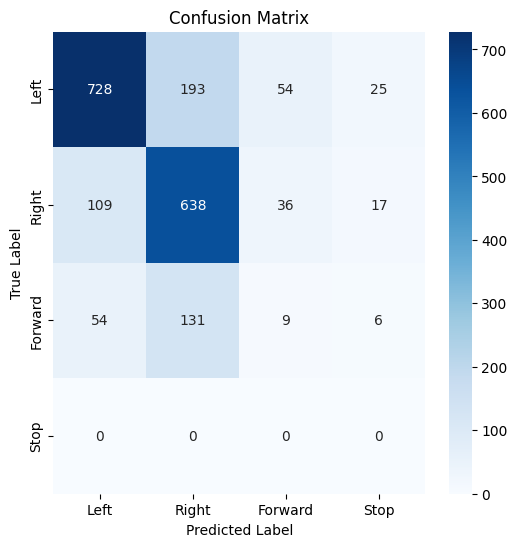

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(all_true_actions, all_predicted_actions)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=env.actions, yticklabels=env.actions)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

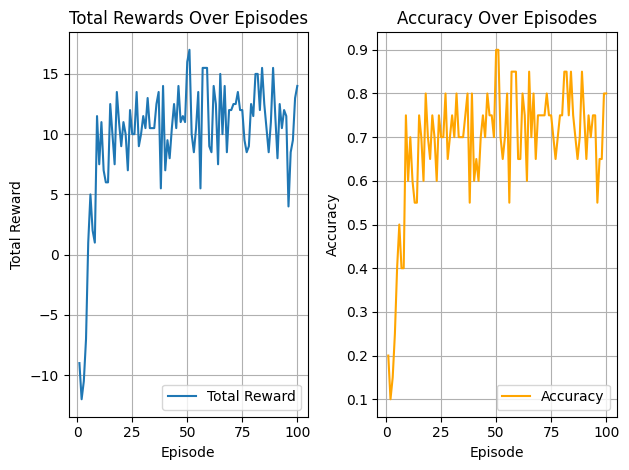

In [ ]:
# Plot Rewards
plt.subplot(1, 2, 1)
plt.plot(range(1, len(episode_rewards) + 1), episode_rewards, label='Total Reward') # Change x-axis range
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Rewards Over Episodes')
plt.grid(True)
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(episode_accuracies) + 1), episode_accuracies, label='Accuracy', color='orange') # Change x-axis range
plt.xlabel('Episode')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Episodes')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
dqn.save('/content/drive/MyDrive/Colab Notebooks/RL-AutoNav/optimized_dqn_model.h5')